In [1]:
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
from pprint import pprint

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

import re
from nltk.stem import WordNetLemmatizer

## 1. DATA LOAD

In [2]:
train = pd.read_json('train.json', encoding = 'UTF-8')
test = pd.read_json('test.json', encoding = 'UTF-8')

COPY

In [3]:
df = train.copy()

print(df.shape)
df.tail(2)

(39774, 3)


,cuisine,id,ingredients
39772,chinese,41882,"[boneless chicken skinless thigh, minced garli..."
39773,mexican,2362,"[green chile, jalapeno chilies, onions, ground..."


## II. DATA 탐색 (Before Pre-processing)

#### 1) Count

In [4]:
df.count()

cuisine        39774
id             39774
ingredients    39774
dtype: int64

#### 2) Number of NaNs for each column

In [5]:
df.isnull().sum()

cuisine        0
id             0
ingredients    0
dtype: int64

#### 3) Cuisine Types

In [6]:
print('Cusine은 {}개 입니다.'.format(len(df.cuisine.value_counts())))
df.cuisine.value_counts()

Cusine은 20개 입니다.


italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

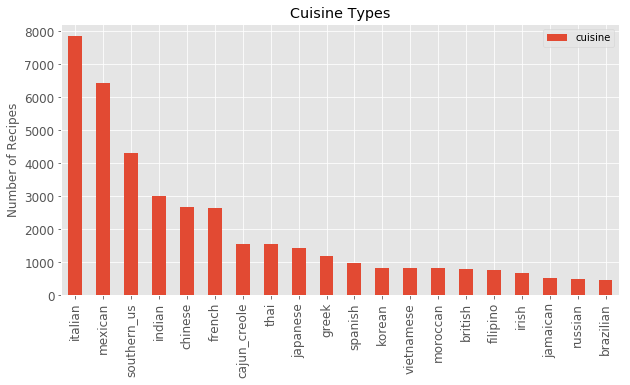

In [7]:
# cuisine type 시각화

plt.style.use('ggplot')
df.cuisine.value_counts().plot(kind = 'bar',
                              title='Cuisine Types',
                              figsize=(10,5),
                              legend=True,
                              fontsize=12)
plt.ylabel("Number of Recipes", fontsize=12)
plt.show()

#### 4) Ingredients Types
1. ingredient의 종류와 개수는 어떻게 되는가?
2. 각 recipe에 쓰이는 ingredient는 몇개인가?

!! ingredient column은 각 recipe 별로 어떤 재료가 쓰여 있는지 list 형식으로 되어 있다.

In [8]:
### 각 row 마다의 recipe 별 ingredient를 count하기 위한 작업

# 여기서는 ingredient가 각 1개씩 count 될 것이다.
bag_of_ingredients = [Counter(ingredient) for ingredient in df.ingredients]

# 각 ingredients의 종류별 개수
sum_of_ingredients = sum(bag_of_ingredients, Counter())

########################################################################################

### sum_of_ingredients를 dataframe에 넣기 위한 작업

# dict -> list -> dataframe
sum_of_ingredients_dict = dict(sum_of_ingredients)
sum_of_ingredients_list = list(sum_of_ingredients_dict.items())

ingredients_df = pd.DataFrame(sum_of_ingredients_list)
ingredients_df.columns = ['ingredient', 'count']
ingredients_df.tail(2)

print('전처리 전 ingredient는 총 {}개 입니다.'.format(len(ingredients_df)))

전처리 전 ingredient는 총 6714개 입니다.


In [9]:
# ingredient 순위 -> 시각화
# 각 나라별 recipe에 쓰이는 재료의 개수 평균

## III. Pre-processing

1. 대문자를 소문자로
2. 상품명 제거 : Oscar Mayer Deli Fresh Smoked,  '®, ™'가 있는 것도 상품명
3. 재료손질 & 재료상태 제거 : chopped, ground, fresh, powdered, sharp, crushed, grilled, roasted, sliced, cooked, shredded, cracked, minced, finely...
4. ','(콤마) 뒤에 있는 것은 재료 손질 방법이므로 불필요하다고 생각됨
5. digit(숫자) 제거
6. 특수문자 제거 : %, -, (, ), '.', oz. , ....
7. lemmatize를 이용하여 단어를 원형으로 변경

In [10]:
def pre_processing_(recipe):
    
    wnl = WordNetLemmatizer()
    
    # 1. lower 함수를 이용하여 대문자를 소문자로 변경
    recipe = [str.lower(ingredient) for ingredient in recipe]
    
    # 2. 상품명을 제거하는 함수
    def delete_brand_(ingredient):
        
        # '®'이 있는 브랜드
        ingredient = re.sub("country crock|i can't believe it's not butter!|bertolli|oreo|hellmann's", '', ingredient)
        ingredient = re.sub("red gold|hidden valley|original ranch|frank's|redhot|lipton", '', ingredient)
        ingredient = re.sub("recipe secrets|eggland's best|hidden valley|best foods|knorr|land o lakes", '', ingredient)
        ingredient = re.sub("sargento|johnsonville|breyers|diamond crystal|taco bell|bacardi", '', ingredient)
        ingredient = re.sub("mccormick|crystal farms|yoplait|mazola|new york style panetini", '', ingredient)
        ingredient = re.sub("ragu|soy vay|tabasco|truvía|crescent recipe creations|spice islands", '', ingredient)
        ingredient = re.sub("wish-bone|honeysuckle white|pasta sides|fiesta sides", '', ingredient)
        ingredient = re.sub("veri veri teriyaki|artisan blends|home originals|greek yogurt|original ranch", '', ingredient)
        ingredient = re.sub("jonshonville", '', ingredient)

        # '™'이 있는 브랜드
        ingredient = re.sub("old el paso|pillsbury|progresso|betty crocker|green giant|hellmannâ€", '', ingredient)

        # 'oscar mayer deli fresh smoked' 브랜드
        ingredient = re.sub("oscar mayer deli fresh smoked", '', ingredient)
        
        return ingredient
    
    # 3. 재료 손질, 상태를 제거하는 함수
    def delete_state_(ingredient):
    
        ingredient = re.sub('frozen|chopped|ground|fresh|powdered', '', ingredient)
        ingredient = re.sub('sharp|crushed|grilled|roasted|sliced', '', ingredient)
        ingredient = re.sub('cooked|shredded|cracked|minced|finely', '', ingredient)        
     
        return ingredient
    
    # 4. 콤마 뒤에 있는 재료손질방법을 제거하는 함수
    def delete_comma_(ingredient):
        
        ingredient = ingredient.split(',')
        ingredient = ingredient[0]
        
        return ingredient

    ## 그외 전처리 함수 (숫자제거, 특수문자제거, 원형으로변경)
    def original_(ingredient):
        
        # 숫자제거
        ingredient = re.sub('[0-9]', '', ingredient)
        
        # 특수문자 제거
        ingredient = ingredient.replace("oz.", '')
        ingredient = re.sub('[&%()®™/]', '', ingredient)
        ingredient = re.sub('[-.]', '', ingredient)
        
        # lemmatize를 이용하여 단어를 원형으로 변경
        ingredient = wnl.lemmatize(ingredient)
        
        return ingredient

    # 양 끝 공백을 제거하는 함수
    def delete_space_(ingredient):
        
        ingredient = ingredient.strip()
        
        return ingredient

    recipe = [delete_brand_(ingredient) for ingredient in recipe]
    recipe = [delete_state_(ingredient) for ingredient in recipe]
    recipe = [delete_comma_(ingredient) for ingredient in recipe]
    recipe = [original_(ingredient) for ingredient in recipe]
    recipe = [delete_space_(ingredient) for ingredient in recipe]

    return recipe

In [11]:
df['ingredients'] = df['ingredients'].apply(lambda x : pre_processing_(x))

## IV. Pre-Processing 후 Data set의 변화

In [12]:
### 각 row 마다의 recipe 별 ingredient를 count하기 위한 작업

# 여기서는 ingredient가 각 1개씩 count 될 것이다.
bag_of_ingredients = [Counter(ingredient) for ingredient in df.ingredients]

# 각 ingredients의 종류별 개수
sum_of_ingredients = sum(bag_of_ingredients, Counter())

########################################################################################

### sum_of_ingredients를 dataframe에 넣기 위한 작업

# dict -> list -> dataframe
sum_of_ingredients_dict = dict(sum_of_ingredients)
sum_of_ingredients_list = list(sum_of_ingredients_dict.items())

ingredients_df = pd.DataFrame(sum_of_ingredients_list)
ingredients_df.columns = ['ingredient', 'count']
ingredients_df.tail(2)

print('전처리 후 ingredient는 총 {}개 입니다.'.format(len(ingredients_df)))

전처리 후 ingredient는 총 6313개 입니다.


## V. Model Selection